In [1]:
# Install coxkan
! pip install coxkan

# CoxKAN Introductory Demo

In [2]:
from coxkan import CoxKAN
from sklearn.model_selection import train_test_split
import numpy as np

### Synthetic Dataset Example

The code below generates a synthetic survival dataset under the hazard function

$$\text{Hazard, } h(t, \mathbf{x}) = 0.01 e^{\theta(\mathbf{x})},$$

where

$$\text{Log-Partial Hazard, }\theta (\mathbf{x}) = \tanh (5x_1) + \sin (2 \pi x_2)$$

and a **uniform censoring distribution**.

In [3]:
from coxkan.datasets import create_dataset

log_partial_hazard = lambda x1, x2: np.tanh(5*x1) + np.sin(2*np.pi*x2)

df = create_dataset(log_partial_hazard, baseline_hazard=0.01, n_samples=10000, seed=42)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train.head()

Concordance index of true expression: 0.7524


,x1,x2,duration,event
9254,0.541629,-0.706251,42.270669,1
1561,-0.526259,-0.492606,54.283488,1
1670,-0.238753,-0.326589,361.569903,1
6087,-0.588024,0.742029,57.335278,0
6669,-0.739364,-0.302907,95.975668,1


### Train CoxKAN:

train loss: 2.77e+00 | val loss: 2.50e+00: 100%|██████████████████| 100/100 [00:51<00:00,  1.92it/s]



CoxKAN C-Index:  0.7553786667818724


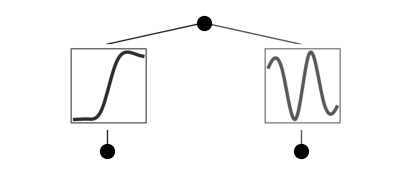

In [4]:
ckan = CoxKAN(width=[2,1], grid=5, seed=42)

_ = ckan.train(
    df_train, 
    df_test, 
    duration_col='duration', 
    event_col='event',
    opt='Adam',
    lr=0.01,
    steps=100)

# evaluate CoxKAN
cindex = ckan.cindex(df_test)
print("\nCoxKAN C-Index: ", cindex)

# plot CoxKAN
fig = ckan.plot()

### Symbolic Fitting:

In [5]:
# auto-symbolic fitting
_ = ckan.auto_symbolic(lib=['x^2', 'sin', 'exp', 'log', 'sqrt', 'tanh'], verbose=False)

# train affine parameters
_ = ckan.train(df_train, df_test, duration_col='duration', event_col='event', opt='LBFGS', steps=10)

display(ckan.symbolic_formula(floating_digit=1)[0][0])

train loss: 2.77e+00 | val loss: 2.50e+00: 100%|████████████████████| 10/10 [00:12<00:00,  1.26s/it]


-1.0*sin(6.3*x2 + 9.4) + 1.0*tanh(4.4*x1)

### Symbolic Expression Evaluation CoxKAN:

We see CoxKAN approximately recovers the true log-partial hazard:

$\hat{\theta}_{KAN} = \tanh(4.4 x_1) -\sin(6.3 x_2 + 9.4) \approx \tanh(5 x_1) -\sin(2 \pi x_2 + 3 \pi) = \tanh(5 x_1)+ \sin(2 \pi x_2)$

In [6]:
log_partial_hazard = lambda x1, x2: np.tanh(5*x1) + np.sin(2*np.pi*x2)
Obtained_symbolic_expression =  lambda x1, x2: (-1.0*np.sin((6.3*x2)+9.4))+(1.0*np.tanh((4.4*x1)))

In [7]:
check1 = []
check2 = []
for i in np.arange(0,2*np.pi,0.1):
    for j in np.arange(0,2*np.pi,0.1):
        check1.append(log_partial_hazard(i,j))
        check2.append(Obtained_symbolic_expression(i,j))

In [8]:
results = []
for i in range(len(check1)):
    results.append((check2[i] - check1[i])**2)

rmse = np.sqrt((sum(results)/len(results)))
rmse

0.03078551065178464

### Train CoxKAN:

train loss: 2.77e+00 | val loss: 2.50e+00: 100%|██████████████████| 100/100 [01:21<00:00,  1.23it/s]



CoxKAN C-Index:  0.7576267211425115


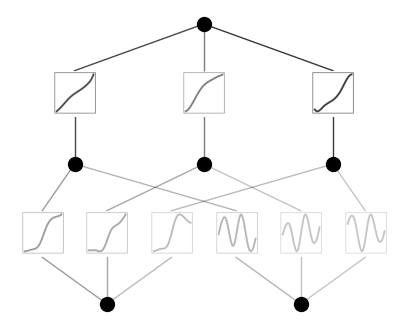

In [9]:
ckan = CoxKAN(width=[2,3,1], grid=5, seed=42)

_ = ckan.train(
    df_train, 
    df_test, 
    duration_col='duration', 
    event_col='event',
    opt='Adam',
    lr=0.01,
    steps=100)

# evaluate CoxKAN
cindex = ckan.cindex(df_test)
print("\nCoxKAN C-Index: ", cindex)

# plot CoxKAN
fig = ckan.plot()

### Symbolic Fitting:

In [12]:
# auto-symbolic fitting
_ = ckan.auto_symbolic(lib=['x','x^2','x^3','x^4','sin', 'exp', 'log', 'sqrt', 'tanh'], verbose=False)

# train affine parameters
_ = ckan.train(df_train, df_test, duration_col='duration', event_col='event', opt='LBFGS', steps=10)

display(ckan.symbolic_formula(floating_digit=1)[0][0])

train loss: 2.77e+00 | val loss: 2.50e+00: 100%|████████████████████| 10/10 [00:46<00:00,  4.66s/it]


3.3*sqrt(-0.2*sin(5.9*x2 - 3.3) + 0.1*tanh(3.8*x1 - 0.4) + 1) + 0.5*tanh(-0.6*sin(6.5*x2 - 9.4) + 1.5*tanh(3.2*x1 - 0.2) + 1.6) - 2.7*tanh(0.3*sin(6.5*x2 + 9.5) - 0.3*tanh(5.4*x1) + 0.6)

### Symbolic Expression Evaluation CoxKAN:

We see CoxKAN approximately recovers the true log-partial hazard:

$\hat{\theta}_{KAN} = \tanh(4.4 x_1) -\sin(6.3 x_2 + 9.4) \approx \tanh(5 x_1) -\sin(2 \pi x_2 + 3 \pi) = \tanh(5 x_1)+ \sin(2 \pi x_2)$

In [21]:
log_partial_hazard = lambda x1, x2: np.tanh(5*x1) + np.sin(2*np.pi*x2)
long_symbolic_expression =  lambda x1, x2: (3.3*np.sqrt((-0.2*np.sin((5.9*x2)-3.3))+(0.1*np.tanh((3.8*x1)-0.4))+1))+(0.5*np.tanh((-0.6*np.sin((6.5*x2)-9.4))+(1.5*np.tanh((3.2*x1)-0.2))+1.6))-(2.7*np.tanh(0.3*np.sin((6.4*x2)+9.5)-(0.3*np.tanh((5.4*x1)))+0.6))



In [22]:
l1 = []
l2 = []
for i in np.arange(0,2*np.pi,0.1):
    for j in np.arange(0,2*np.pi,0.1):
        l1.append(log_partial_hazard(i,j))
        l2.append(long_symbolic_expression(i,j))

In [23]:
len(l1)

3969

In [24]:
len(l2)

3969

In [25]:
# Create new list of equal length for your predictions
l3 = []

In [26]:
for i in range(len(l1)):
    l3.append((l2[i] - l1[i])**2)

#print(l3)

In [27]:
rmse = np.sqrt((sum(l3)/len(l3)))
rmse

2.2231100852976673

### Real dataset example

Using default train-test split (used in DeepSurv paper).


train loss: 2.60e+00 | val loss: 2.41e+00: 100%|██████████████████| 100/100 [00:17<00:00,  5.69it/s]



CoxKAN C-Index:  0.679797402909703


Piecewise((0.06, Eq(meno, 0)), (0.22, Eq(meno, 1.0)), (nan, True)) + Piecewise((0.36, Eq(hormon, 0)), (0.02, Eq(hormon, 1.0)), (nan, True)) + Piecewise((-0.16, Eq(size, 0)), (0.09, Eq(size, 1.0)), (0.36, Eq(size, 2.0)), (nan, True)) + 0.759 - 1.16*exp(-0.03*(-nodes - 0.59)**2) - 0.31*exp(-5.69*(1 - 0.02*age)**2)

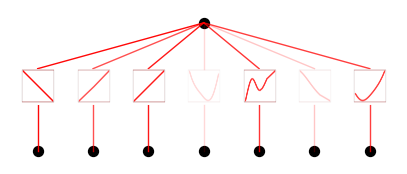

In [28]:
from coxkan.datasets import gbsg

# load dataset
df_train, df_test = gbsg.load(split=True)
name, duration_col, event_col, covariates = gbsg.metadata()

# init CoxKAN
ckan = CoxKAN(width=[len(covariates), 1], seed=42)

# pre-process and register data
df_train, df_test = ckan.process_data(df_train, df_test, duration_col, event_col, normalization='standard')

# train CoxKAN
_ = ckan.train(
    df_train, 
    df_test, 
    duration_col=duration_col, 
    event_col=event_col,
    opt='Adam',
    lr=0.01,
    steps=100)

print("\nCoxKAN C-Index: ", ckan.cindex(df_test))

# Auto symbolic fitting
fit_success = ckan.auto_symbolic(verbose=False)
display(ckan.symbolic_formula(floating_digit=2)[0][0])

# Plot coxkan
fig = ckan.plot(beta=20)